## Data Pre Processing

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()

In [3]:
df = pd.read_csv('data\PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df.dtypes

PJME_MW    float64
dtype: object

In [4]:
df.head(-5)

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 15:00:00,38737.0
2018-01-01 16:00:00,39337.0
2018-01-01 17:00:00,41213.0


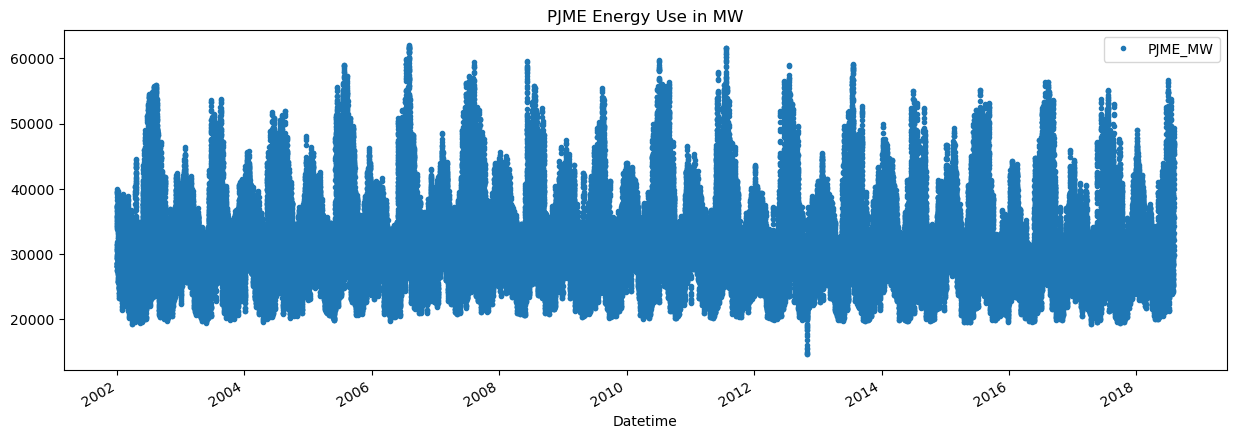

In [5]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

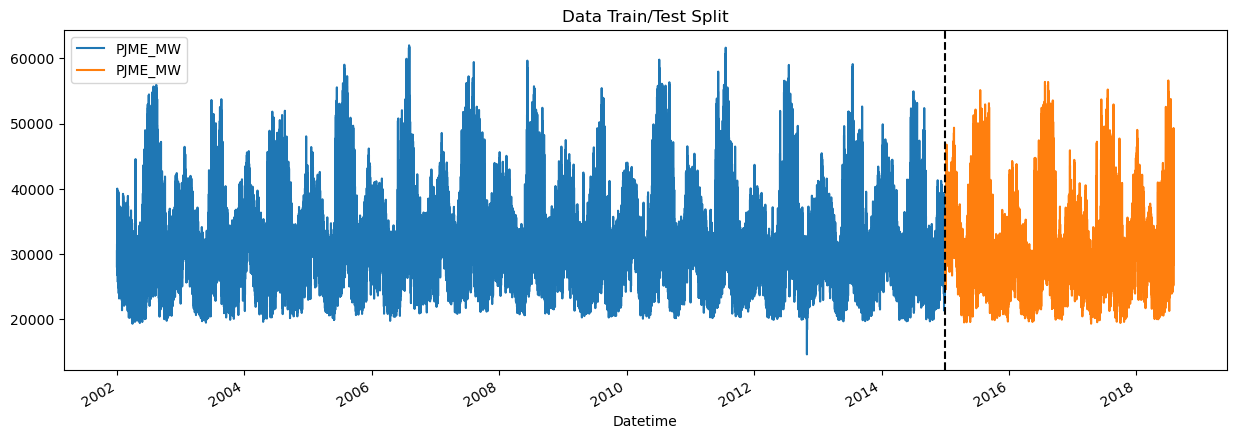

In [6]:
# train on data from 2002 to end of 2015, test on 2015 onwards
train = df.loc[df.index < pd.to_datetime('01-01-2015')]
test = df.loc[df.index >= pd.to_datetime('01-01-2015')]

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set')
test.plot(ax=ax, label='Test Set')

# convert string to datetime for plotting
ax.axvline(pd.to_datetime('01-01-2015'), color='black', ls='--')
ax.legend()
plt.title('Data Train/Test Split')
plt.show()

In [7]:
def create_features(df):
    """
    create time series features based on time series 
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

## Data Visualization

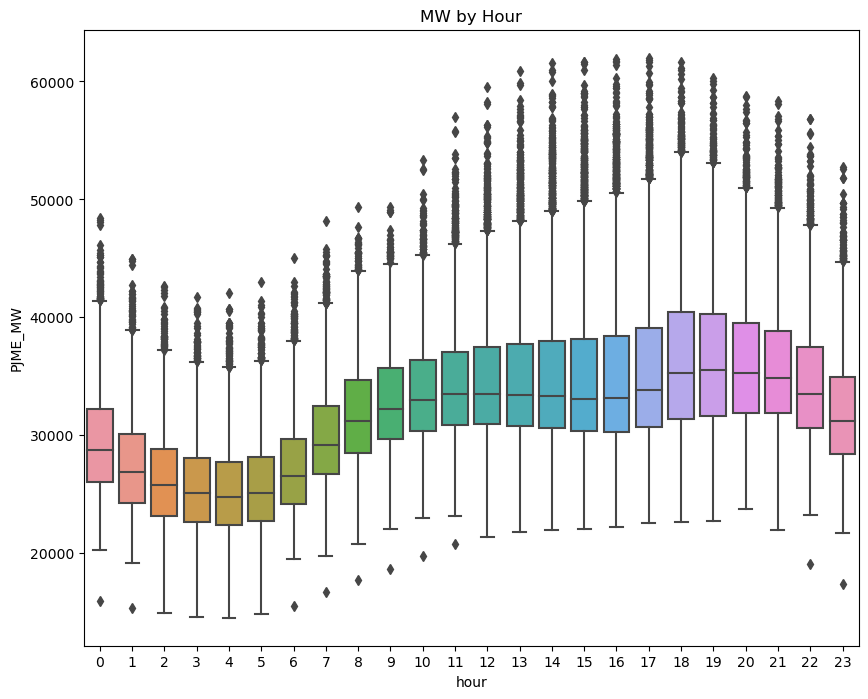

In [8]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

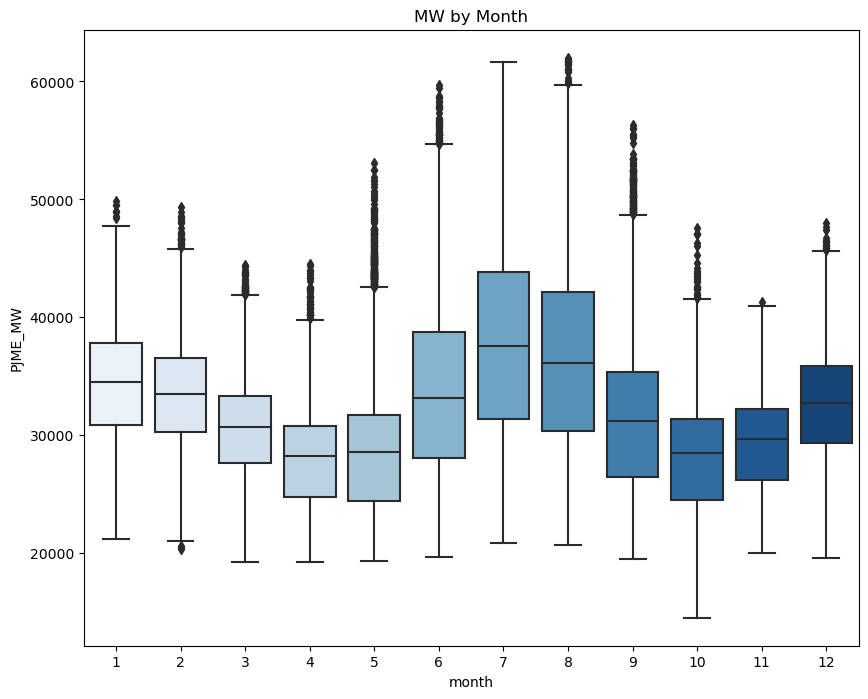

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

## Model Creation
### Gradient Boosting (XGBoost)

In [10]:
# Prepping Features
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [21]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# Paramter grid
param_grid = {
    'n_estimators': [1000, 2000, 3000],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
}

xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', booster='gbtree', base_score=0.5, early_stopping_rounds=50)
tscv = TimeSeriesSplit(n_splits=5)

# Initializing/Fiting model and grid search
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=100)

# Print the best parameters and best score
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best score found: {grid_search.best_score_}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[0]	validation_0-rmse:30350.75239
[100]	validation_0-rmse:3825.55352
[125]	validation_0-rmse:3890.25196
Best parameters found: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 1000}
Best score found: -12650957.91873837


In [28]:
reg = grid_search.best_estimator_ 

## Feature Importance Analysis

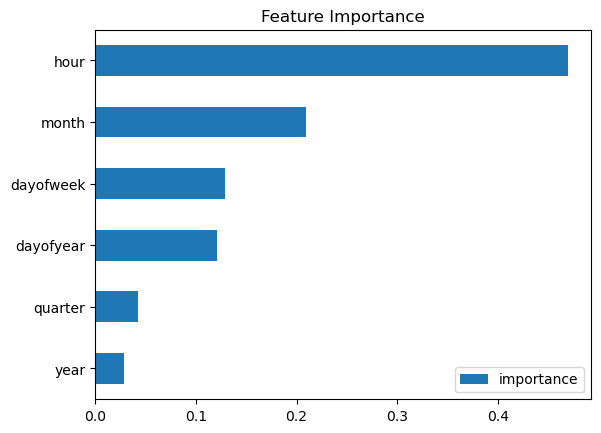

In [29]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

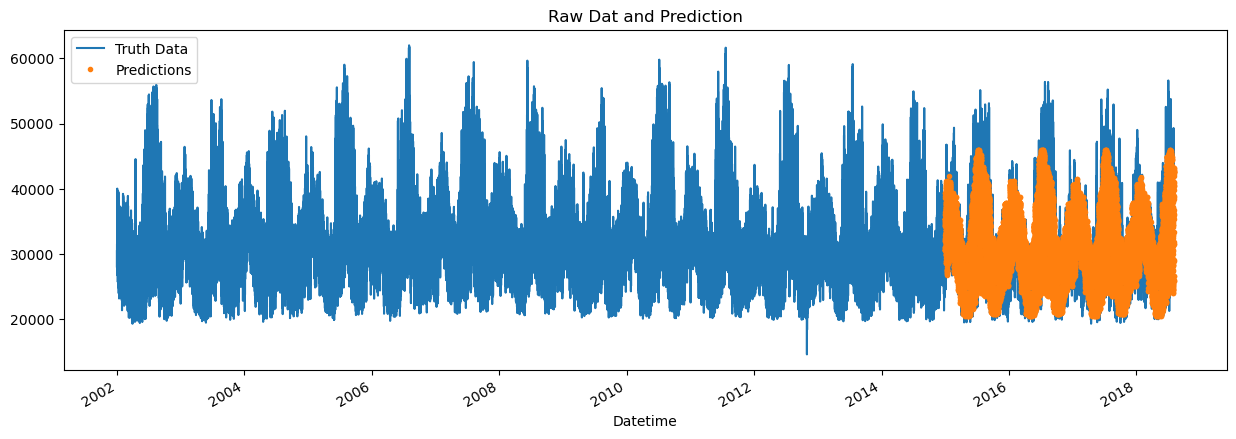

In [32]:
#Merge data
predictions = reg.predict(X_test)
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

#### Examining 1 week of data

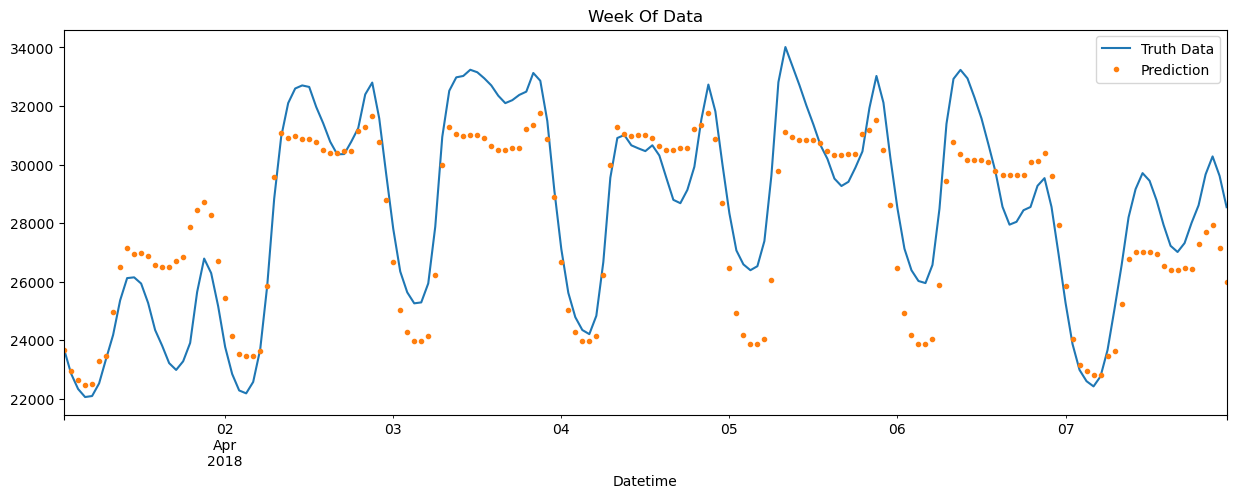

In [33]:
#Real Data
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')

#Predicted Data
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')

plt.legend(['Truth Data','Prediction'])
plt.show()


## Model Peformance

In [36]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

RMSE_score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
r2 = r2_score(test['PJME_MW'], test['prediction'])

print(f'RMSE Score on Test set: {RMSE_score:0.2f}')
print(f'R^2 Score on Test set: {r2:0.3f}')

RMSE Score on Test set: 3763.34
R^2 Score on Test set: 0.660


In [16]:
#Looking at best and worst error
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(-5)

date
2016-08-13    12879.484619
2016-08-14    12772.887207
2015-02-20    11186.031494
2016-09-09    10966.513102
2016-09-10    10889.102214
                  ...     
2016-09-16      711.019694
2016-12-29      706.143392
2017-04-07      687.475911
2015-11-06      678.310140
2018-05-16      569.951009
Name: error, Length: 1306, dtype: float64